# Compute and Analyze Classifier Metrics

The snakemake pipeline output the probability of 0 / 1 for each cell for each classifier. Here, we compute and save many common metrics from these probabilities. Here we analyze the classification results of each allele.

In [33]:
# imports
import os
import glob
import operator
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from functools import reduce
import sys
sys.path.append("../..")
from img_utils import *

letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}
channel_list = list(channel_dict_rev.values())[:-3]

%matplotlib inline
## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]
BINS = 50

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2
AUROC_THRESHOLDS = [0.95, 0.99]

## Override some constants
BIO_REP_BATCHES_DICT = {
    "2025_05_Batch_17": ('2025_05_23_Batch_17', '2025_05_23_Batch_17_media_change')
}
FEAT_SETS = ["GFP", "DNA", "AGP", "Morph", "TxControl"] ## "Mito", 

## 1. Loading data

### QC

In [6]:
def get_plate_well_sum(batch, img_qc_dir, output_dir, bins=BINS, write_pq=False):
    plate_sum = pl.read_parquet(f"{img_qc_dir}/{batch}/plate_sum_stats.parquet")
    plate_well_sum = pl.read_parquet(f"{img_qc_dir}/{batch}/plate_well_sum_stats.parquet")
    # plate_site_sum = pl.read_parquet(f"../outputs/1.plate_bg_summary/{batch}/plate_site_channel.parquet")
    # plate_site_sum = plate_site_sum.filter(~(pl.col("channel").str.contains("Brightfield"))).sort(by=["plate","well"]).join(plate_sum, on=["plate","channel"], how="left", suffix="_plate")

    # plate_well_sum.filter(~(pl.col("channel").str.contains("Brightfield"))).sort(by=["plate","well"])
    plate_well_sum = plate_well_sum.filter(
        ~(pl.col("channel").str.contains("Brightfield"))
    ).join(
        plate_sum.rename({"perc_50": "median_plate"}), on=["plate","channel"], how="left", suffix="_plate"
    ).sort(by=["plate", "well"])

    plates = sorted(plate_well_sum["plate"].unique())
    plate_well_sum_with_metrics = pl.DataFrame()
    for plate in plates: #plate_well_sum.group_by("plate"):
        group = plate_well_sum.filter(pl.col("plate")==plate)
        # plate = group[0][0]
        # fig, axes = plt.subplots(1, 4, figsize=(15, 3))
        for channel in channel_list:
            # print(plate, channel)
            plate_channel_plate = plate_well_sum.filter(
                (pl.col("plate")==plate)&(pl.col("channel")==channel)
            ).with_columns(
                (pl.col("perc_99") / pl.col("perc_25")).alias("s2n_ratio")
            ).filter(
                (~(pl.col("s2n_ratio").is_infinite()))&(~(pl.col("s2n_ratio").is_nan()))
            ).sort(by="s2n_ratio")
            if channel == "GFP":
                plate_channel_plate = plate_channel_plate.with_columns(
                    np.log10(pl.col("s2n_ratio")+1e-4).alias("s2n_ratio")
                )
            s2n_ratios = plate_channel_plate["s2n_ratio"].to_numpy()
            counts, edges = np.histogram(s2n_ratios, bins=bins)
            # 4) the right edge of the first bin is our cutoff
            threshold = edges[1]
            plate_channel_plate = plate_channel_plate.with_columns(
                pl.lit(threshold).alias("s2n_threshold"),
                (pl.col("s2n_ratio") <= threshold).alias("is_bg")
            )
            
            # sns.histplot(plate_channel_plate["s2n_ratio"], ax=axes[channel_list.index(channel)], bins=100) # log_scale=True
            # axes[channel_list.index(channel)].axvline(threshold, color='red', linestyle='--', label='Threshold')
            # if channel == "GFP":
            #     axes[channel_list.index(channel)].set_xlabel("log10(s2n_ratio)")
            # else:
            #     axes[channel_list.index(channel)].set_xlabel("s2n_ratio")
            # axes[channel_list.index(channel)].set_title(channel)
            plate_well_sum_with_metrics = pl.concat([plate_well_sum_with_metrics, plate_channel_plate])

        # fig.suptitle(f"{plate}",y=1.05)
        # fig.subplots_adjust(wspace=0.25)

    output_pq_file = f"{output_dir}/{batch}/plate_well_sum_with_qc_metrics.parquet"
    # display(plate_well_sum_with_metrics)
    if os.path.exists(output_pq_file):
        print("Output exists at:", output_pq_file)
        
    if write_pq:
        os.makedirs(f"{output_dir}/{batch}")
        print("Writed outputs at:", output_pq_file)
        plate_well_sum_with_metrics.write_parquet(
            output_pq_file
        )
        
    return plate_well_sum_with_metrics

In [8]:
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch in bio_rep_batches:
        output_dir = f"{IMGS_QC_METRICS_DIR}/{bio_rep}"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        plate_well_sum_with_metrics = get_plate_well_sum(batch, IMGS_QC_BG_SUM_DIR, output_dir, write_pq=False)
        break

Output exists at: /home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/3.downstream_analyses/inputs/plate_well_qc_metrics/2025_05_Batch_17/2025_05_23_Batch_17/plate_well_sum_with_qc_metrics.parquet


In [11]:
plate_well_sum_with_metrics.unique("channel")

plate,well,channel,mean,std,perc_25,perc_50,perc_75,perc_80,perc_90,perc_95,perc_99,mean_plate,std_plate,perc_25_plate,median_plate,perc_75_plate,perc_80_plate,perc_90_plate,perc_95_plate,perc_99_plate,s2n_ratio,s2n_threshold,is_bg
str,str,str,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,bool
"""2025_04_01_B17A9R1""","""A16""","""Mito""",2192.242774,1394.439535,1236,1974,2983,3242,3961,4663,6440,1667.073105,1985.352274,191,787,2665,3094,4247,5337,8445,5.210356,6.513092,true
"""2025_04_01_B17A9R1""","""E01""","""AGP""",187.732895,24.686079,171,190,205,209,217,225,238,273.394992,1033.712561,176,197,216,222,239,292,1761,1.391813,2.702884,true
"""2025_04_01_B17A9R1""","""B16""","""GFP""",137.384778,17.841894,125,139,151,153,159,164,172,269.788374,1917.010886,129,144,157,161,172,211,1876,0.13865,0.188979,true
"""2025_04_01_B17A9R1""","""B16""","""DAPI""",177.43441,63.025075,154,174,190,194,203,210,409,251.279457,201.093456,164,187,215,231,493,724,1076,2.655844,2.790532,true


### Read in platemap metadata and imaging well QC info

In [12]:
allele_meta_df = pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
            # display(allele_meta_df.head())
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    img_well_qc_sum = plate_well_sum_with_metrics
    img_well_qc_sum = img_well_qc_sum.with_columns(
        pl.col("channel").replace("DAPI", "DNA").alias("channel")
    )
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio")
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [49]:
allele_meta_df.unique("gene_allele").filter(
    pl.col("node_type")=="allele"
)

plate_map_name,well_position,symbol,gene_allele,source_plate,source_well,source_numb,dest_plate,dest_well,dest_numb,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,nt_change_cdna,aa_change,ccsb_mutation_id,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,sequencing_confidence,plate_map
str,str,str,str,str,str,f64,str,str,i64,str,str,str,str,f64,str,str,str,str,str,str,str,str
"""B17A9R1_P1""","""G01""","""SEMA4A""","""SEMA4A_Asp167Val""","""colPCR_attL_LacosteBth2_01""","""D01""",4.0,"""664_Lacoste_P01_Test_T1""","""D01""",4,"""G01""","""B17A9R1""","""B17A9R2""","""allele""",490.0,"""500A>T""","""Asp167Val""","""CCSBVarC015813""",null,null,null,null,"""B17A9R1_P1"""
"""B17A9R1_P1""","""C03""","""SEMA4A""","""SEMA4A_Gly32Val""","""colPCR_attL_LacosteBth2_01""","""B02""",10.0,"""664_Lacoste_P01_Test_T1""","""B02""",10,"""C03""","""B17A9R1""","""B17A9R2""","""allele""",490.0,"""95G>T""","""Gly32Val""","""CCSBVarC015826""",null,null,null,null,"""B17A9R1_P1"""
"""B17A9R1_P1""","""A23""","""MCOLN1""","""MCOLN1_Glu123Lys""","""colPCR_attL_LacosteBth2_01""","""C12""",91.0,"""664_Lacoste_P01_Test_T1""","""A12""",89,"""A23""","""B17A9R1""","""B17A9R2""","""allele""",3581.0,"""367G>A""","""Glu123Lys""","""CCSBVarC016262""",null,null,null,null,"""B17A9R1_P1"""
"""B17A9R1_P1""","""G15""","""STAG2""","""STAG2_Ile1060Val""","""colPCR_attL_LacosteBth2_01""","""G08""",63.0,"""664_Lacoste_P01_Test_T1""","""D08""",60,"""G15""","""B17A9R1""","""B17A9R2""","""allele""",3304.0,"""3178A>G""","""Ile1060Val""","""CCSBVarC016103""",null,null,null,null,"""B17A9R1_P1"""
"""B17A9R1_P1""","""A17""","""STAG2""","""STAG2_Ile239Val""","""colPCR_attL_LacosteBth2_01""","""D09""",68.0,"""664_Lacoste_P01_Test_T1""","""A09""",65,"""A17""","""B17A9R1""","""B17A9R2""","""allele""",3304.0,"""715A>G""","""Ile239Val""","""CCSBVarC016154""",null,null,null,null,"""B17A9R1_P1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""B17A9R1_P1""","""C21""","""STAG2""","""STAG2_Val1018Met""","""colPCR_attL_LacosteBth2_01""","""D11""",84.0,"""664_Lacoste_P01_Test_T1""","""B11""",82,"""C21""","""B17A9R1""","""B17A9R2""","""allele""",3304.0,"""3052G>A""","""Val1018Met""","""CCSBVarC016095""",null,null,null,null,"""B17A9R1_P1"""
"""B17A9R1_P1""","""E13""","""STAG2""","""STAG2_Gln728His""","""colPCR_attL_LacosteBth2_01""","""F07""",54.0,"""664_Lacoste_P01_Test_T1""","""C07""",51,"""E13""","""B17A9R1""","""B17A9R2""","""allele""",3304.0,"""2184G>T""","""Gln728His""","""CCSBVarC016014""",null,null,null,null,"""B17A9R1_P1"""
"""B17A9R1_P1""","""G09""","""GFAP""","""GFAP_Glu166Lys""","""colPCR_attL_LacosteBth2_01""","""H05""",40.0,"""664_Lacoste_P01_Test_T1""","""D05""",36,"""G09""","""B17A9R1""","""B17A9R2""","""allele""",2920.0,"""496G>A""","""Glu166Lys""","""CCSBVarC015881""",null,null,null,null,"""B17A9R1_P1"""


### Read in the metric per each XGB Classifer

In [14]:
class_info_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv"

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        class_res_df = pl.read_csv(class_info_dir.format(CLASS_ANALYSES_DIR, batch_id))
        class_res_df = class_res_df.with_columns(
            pl.when((pl.col("well_0").str.contains(r"(?:01|P|A|24)"))|(pl.col("well_1").str.contains(r"(?:01|P|A|24)")))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("Well_On_Edge")
        )
        # display(class_res_df)
        for channel in channel_list:
            class_res_df_channel = class_res_df.filter(pl.col("Metadata_Feature_Type")==channel)
            class_res_df_channel = class_res_df_channel.join(
                img_well_qc_sum.filter(pl.col("channel")==channel).select(pl.col(["plate","well","is_bg"])),
                left_on=["Plate","well_0"],
                right_on=["plate","well"]
            ).rename({"is_bg": "well_0_is_bg"})
            class_res_df_channel = class_res_df_channel.join(
                img_well_qc_sum.filter(pl.col("channel")==channel).select(pl.col(["plate","well","is_bg"])),
                left_on=["Plate","well_1"],
                right_on=["plate","well"]
            ).rename({"is_bg": "well_1_is_bg"})
            
            plate_maps = sorted(set(["_".join(pm.split("_")[:-1]) for pm in class_res_df_channel["Plate"].unique()]))
            for pm in plate_maps:
                class_res_ch_pm = class_res_df_channel.filter(pl.col("Plate").str.contains(pm))
                plates = sorted(class_res_ch_pm["Plate"].unique().to_list())
                # fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
                for plate in plates:
                    plate_info = class_res_ch_pm.filter(pl.col("Plate")==plate)
    
                    ## plot the ctrls alleles first
                    plate_info_ctrl = plate_info.filter(pl.col("Metadata_Control"))
                    ctrls_wells = pl.concat([plate_info_ctrl["well_0"], plate_info_ctrl["well_1"]]).unique()
                    agg_group_by_well_0 = plate_info_ctrl.group_by("well_0","allele_0").agg([
                        pl.col("AUROC").mean().alias("AUROC_Mean"),
                        pl.col("well_0_is_bg").max().alias("is_bg")
                    ]).rename(
                        {"well_0": "well", "allele_0": "allele"}
                    )#.with_columns(pl.col("Well_On_Edge").cast(pl.Boolean).alias("Well_On_Edge"))
                    agg_group_by_well_1 = plate_info_ctrl.filter(
                        (pl.col("well_1").is_in(ctrls_wells))&\
                        (~pl.col("well_1").is_in(agg_group_by_well_0["well"]))
                    ).group_by("well_1","allele_1").agg([
                        pl.col("AUROC").mean().alias("AUROC_Mean"),
                        pl.col("well_1_is_bg").max().alias("is_bg")
                    ]).rename(
                        {"well_1": "well", "allele_1": "allele"}
                    )
                    agg_group_by_well = pl.concat(
                        [
                            agg_group_by_well_0.select(pl.col("well","AUROC_Mean","allele","is_bg")),
                            agg_group_by_well_1.select(pl.col("well","AUROC_Mean","allele","is_bg"))
                        ]
                    )
                    ## plot the auroc per each plate for a platemap
                #     plot_platemap(
                #         agg_group_by_well,
                #         plate+f"_{channel}",
                #         well_pos_col="well",
                #         # this is the column to color by (categorical or continuous)
                #         value_col="AUROC_Mean",
                #         # these columns will be concatenated into the annotation text
                #         label_cols=("allele","AUROC_Mean"),
                #         ax=axes[plates.index(plate)//2, plates.index(plate)%2],
                #         value_type="continuous",   # or "continuous"
                #         continuous_cmap="vlag",  # matplotlib colormap for continuous mode
                #         categorical_colors={True: "tomato", False: "skyblue"},     # dict for categorical → color
                #         grid_square="is_bg"
                #     )
                # fig.subplots_adjust(wspace=-.55, hspace=.05)
                # plt.tight_layout()

## 2. Classification metrics

### 2.1 Analyze the metrics per each classifier

Each tested allele should have 2 (protein mislocalization & morphology) * 4 (technical replicates) = 8 classifiers per each batch.

In [37]:
metric_df_dict = {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id_ in bio_rep_batches:
        # print(batch_id)
        metrics_df = pl.read_csv(class_info_dir.format(CLASS_ANALYSES_DIR, batch_id_))
        batch_id = f"B{batch_id_.split('Batch_')[-1].split('_')[0]}"
        
        print(f"====================================={batch_id_} metrics=====================================")
        metrics_df = metrics_df.with_columns(
            pl.when(pl.col("Metadata_Control"))
            .then(pl.lit("1_Ctrl"))
            .otherwise(pl.lit("2_VAR-WT"))
            .alias("Node_Type"),
            pl.col("Metadata_Feature_Type").alias("Classifier_type"),
            # Extract the substring that:
            #  1. Has a digit (\d) immediately before it (anchors the match at a number)
            #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
            #  3. Stops right before the literal 'T'
            pl.col("Plate").str.extract(r"\d(A.*?)T", 1).alias("Allele_set"),
            pl.col("Full_Classifier_ID").str.split("A9").list.first().str.split("_").list.last().alias("Batch")
        )
        # display(metrics_df)
        
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg")),
            left_on=["Plate", "well_0", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({"is_bg": "well_0_is_bg"})
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg")),
            left_on=["Plate", "well_1", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({"is_bg": "well_1_is_bg"})
    
        """
            Calculating controls
        """
        metrics_ctrl_df = metrics_df.filter(
            (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
        )    
        # Filter based on class imbalance
        metrics_ctrl = (
            metrics_ctrl_df
            .select(["Classifier_type", "Batch", "AUROC"])
            .group_by(["Classifier_type", "Batch"])
            .agg([
                pl.col("AUROC").mean().alias("AUROC_mean"),
                pl.col("AUROC").std().alias("AUROC_std")
            ]+[
                pl.col("AUROC").quantile(auroc_thres).alias(f"AUROC_thresh_{auroc_thres*100:.0f}") for auroc_thres in AUROC_THRESHOLDS
            ])
        )
        
        for feat in FEAT_SETS:
            print(f"Total number of control classifiers {feat}:", metrics_ctrl_df.filter((pl.col("Classifier_type") == feat)).shape[0])
            
        print("==========================================================================")
        metric_df_dict[f"{batch_id_}_met"] = metrics_df
        # Merge with metrics_df and decide whether it passed the threshold
        metrics_df_thres = metrics_df.join(metrics_ctrl, on=["Classifier_type", "Batch"])
        # print(metrics_df_thres.head())
        metrics_df_thres = metrics_df_thres.with_columns(
            ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
        )
        
        ## Must be at least min_class_num classifiers per batch
        ## Number of classifiers is the same for localization and morph, so just use morph
        classifier_count = (
            metrics_df_thres.filter(
                (~pl.col("Metadata_Control")) & \
                (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            )
            .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
            .agg([pl.len().alias("Number_classifiers")])
        )
        classifier_count = classifier_count.pivot(
            index=["allele_0", "allele_1", "Allele_set"],
            on="Batch",
            values="Number_classifiers",
        )
        print(f"Total number of unique classifiers for GFP:", classifier_count.shape[0])
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
        print("==========================================================================")
    
        # Must be at least min_class_num classifiers per batch
        # Number of classifiers is the same for localization and morph, so just use morph
        classifier_count = (
            metrics_df_thres.filter(
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
                & (~pl.col("Metadata_Control"))
                & (pl.col("Classifier_type") == "GFP")
            )
            .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
            .agg([pl.len().alias("Number_classifiers")])
        )
        classifier_count = classifier_count.pivot(
            index=["allele_0", "allele_1", "Allele_set"],
            on="Batch",
            values="Number_classifiers",
        )
        # display(classifier_count)
        # break
        print(f"After filtering out classifiers with training imbalance > {TRN_IMBAL_THRES}:")
        print("Total number of unique classifiers:", classifier_count.shape)
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
        print("==========================================================================")

        display(classifier_count)
        classifier_count = classifier_count.filter(
            (pl.col(batch_id) >= MIN_CLASS_NUM)
        )
        print("After filtering out alleles with available number of classifiers < 2:")
        print("Total number of unique classifiers:", classifier_count.shape)
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    
        # filter based on this
        keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
        metrics_df_thres = metrics_df_thres.filter(
            ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
        )
    
        # Filter by imbalance and calculate mean AUROC for each batch
        metrics_wtvar = (
            (
                metrics_df_thres.filter(
                    (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                    (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (~pl.col("Metadata_Control"))
                )
            )
            .select([
                "AUROC",
                "AUROC_zscore",
                "Classifier_type",
                "Batch",
                "allele_0",
                "trainsize_0",
                "testsize_0",
                "trainsize_1",
                "testsize_1",
                "Allele_set",
                "Training_imbalance",
            ]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS])
            .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
            .agg([
                pl.all()
                .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
                .mean()
                .name.suffix("_mean")
            ])
        )
        metric_df_dict[f"{batch_id_}_met_thres"] = metrics_df_thres
        metric_df_dict[f"{batch_id_}_allele_summary"] = metrics_wtvar

        os.makedirs(f"{CLASS_SUMMARY_DIR}/{bio_rep}/{batch_id_}", exist_ok=True)
        metrics_wtvar.write_csv(f"{CLASS_SUMMARY_DIR}/{bio_rep}/{batch_id_}/metrics_summary.csv")

=====================================2025_05_23_Batch_17 metrics=====================================
Total number of control classifiers GFP: 381
Total number of control classifiers DNA: 530
Total number of control classifiers AGP: 295
Total number of control classifiers Morph: 295
Total number of control classifiers TxControl: 0
Total number of unique classifiers for GFP: 78
Total number of unique variant alleles: 78
Total number of unique WT genes: 4
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (78, 4)
Total number of unique variant alleles: 78
Total number of unique WT genes: 4


allele_0,allele_1,Allele_set,B17
str,str,str,u32
"""SEMA4A_Arg667Gly""","""SEMA4A""",null,3
"""GFAP_Ser298Phe""","""GFAP""",null,4
"""STAG2_His295Arg""","""STAG2""",null,4
"""STAG2_Gly1062Val""","""STAG2""",null,4
"""STAG2_Arg667Trp""","""STAG2""",null,4
…,…,…,…
"""GFAP_Val410Leu""","""GFAP""",null,4
"""GFAP_Glu166Asp""","""GFAP""",null,4
"""STAG2_Arg862Gly""","""STAG2""",null,4


After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (75, 4)
Total number of unique variant alleles: 75
Total number of unique WT genes: 4
=====================================2025_05_23_Batch_17_media_change metrics=====================================
Total number of control classifiers GFP: 390
Total number of control classifiers DNA: 448
Total number of control classifiers AGP: 285
Total number of control classifiers Morph: 282
Total number of control classifiers TxControl: 0
Total number of unique classifiers for GFP: 56
Total number of unique variant alleles: 56
Total number of unique WT genes: 4
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (56, 4)
Total number of unique variant alleles: 56
Total number of unique WT genes: 4


allele_0,allele_1,Allele_set,B17
str,str,str,u32
"""STAG2_Arg954Cys""","""STAG2""",null,4
"""SEMA4A_Pro664Leu""","""SEMA4A""",null,4
"""GFAP_Ala26Val""","""GFAP""",null,3
"""MCOLN1_His286Asn""","""MCOLN1""",null,1
"""GFAP_Thr412Ser""","""GFAP""",null,1
…,…,…,…
"""SEMA4A_Pro311Thr""","""SEMA4A""",null,4
"""STAG2_Tyr159Cys""","""STAG2""",null,1
"""STAG2_Thr601Ser""","""STAG2""",null,4


After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (38, 4)
Total number of unique variant alleles: 38
Total number of unique WT genes: 4


## 3. Plotting Metrics

In [39]:
def plot_metric_dist(df, value, batch, col="Node_Type", hue="Node_Type"):
    g = sns.displot(
        data=df, 
        x=value, col=col, kde=True, hue=hue, 
        facet_kws={'sharey': False, 'col_order': sorted(df[col].unique())},
        palette="Set2", hue_order=sorted(df[hue].unique()),
        legend=False, height=4, aspect=1.1
    )
    g.fig.suptitle(f"Batch {batch} {value}", fontsize=12, y=1.)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.9)
    g.savefig(
        os.path.join(OUTPUT_DIR, f"B{batch}_{value}_dist.png"),
        dpi=300,
        bbox_inches="tight"
    )

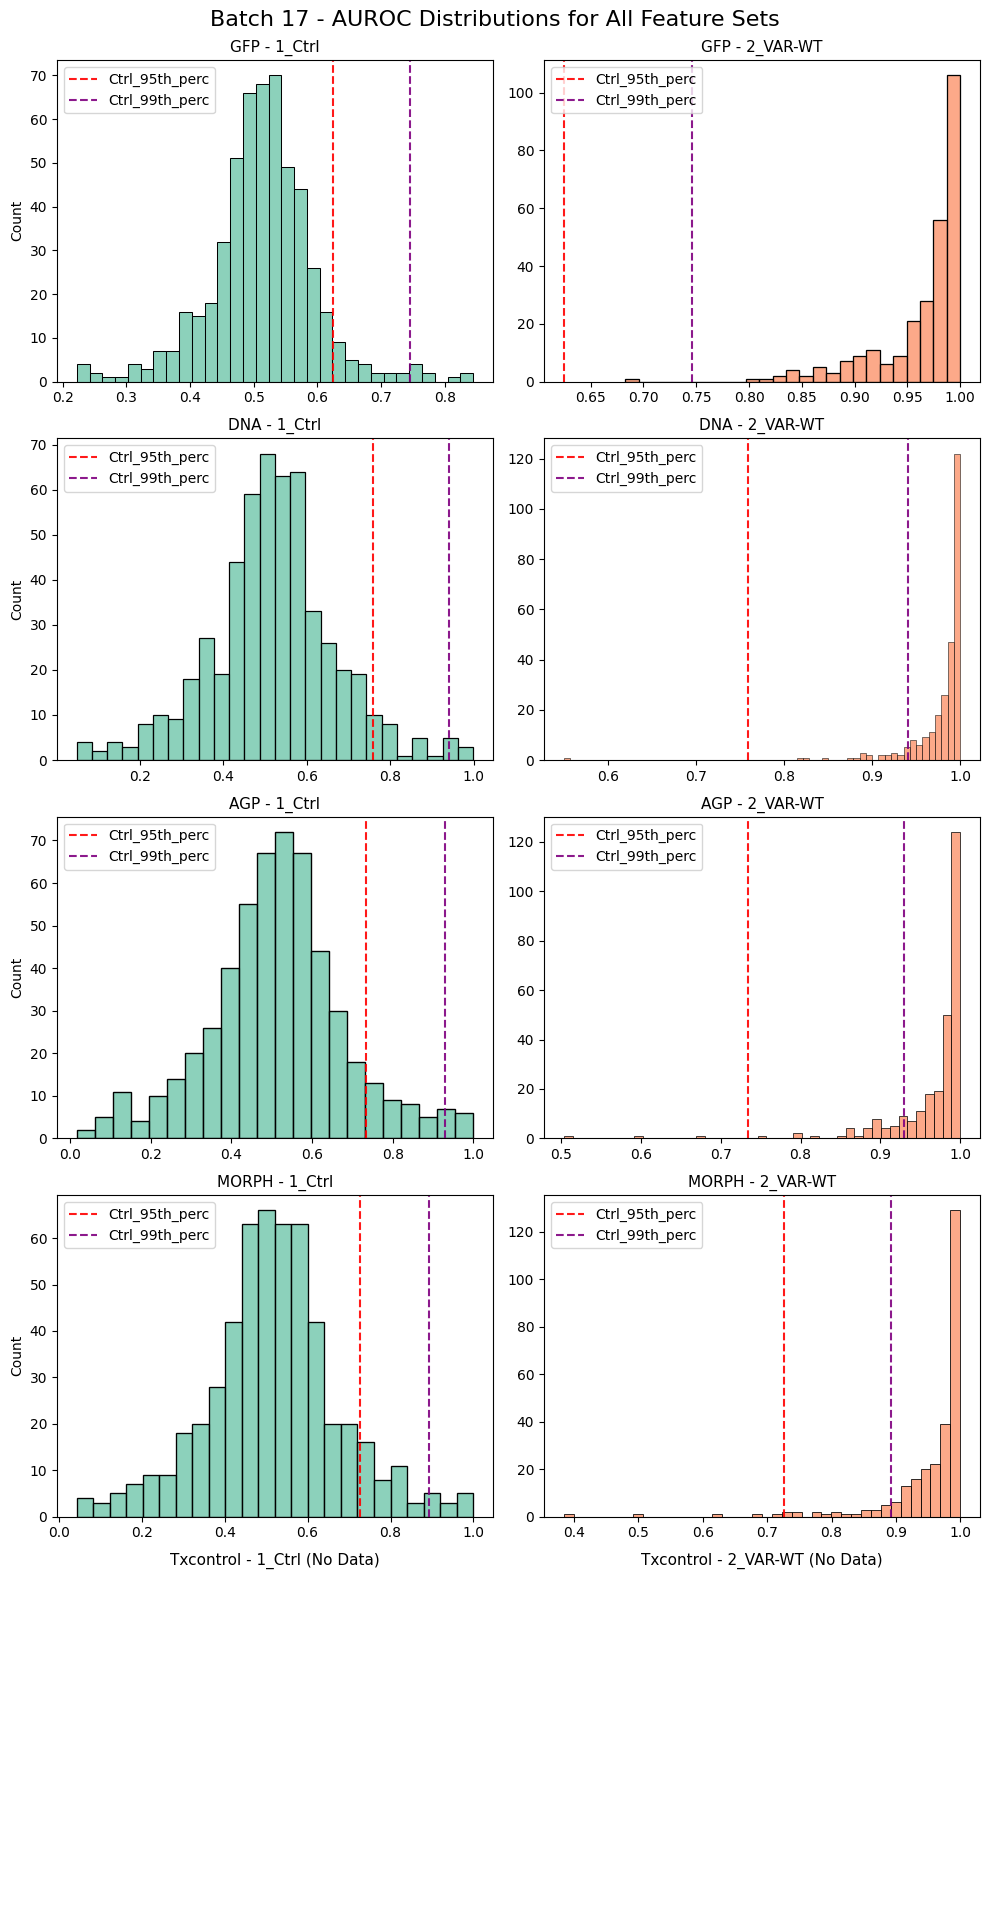

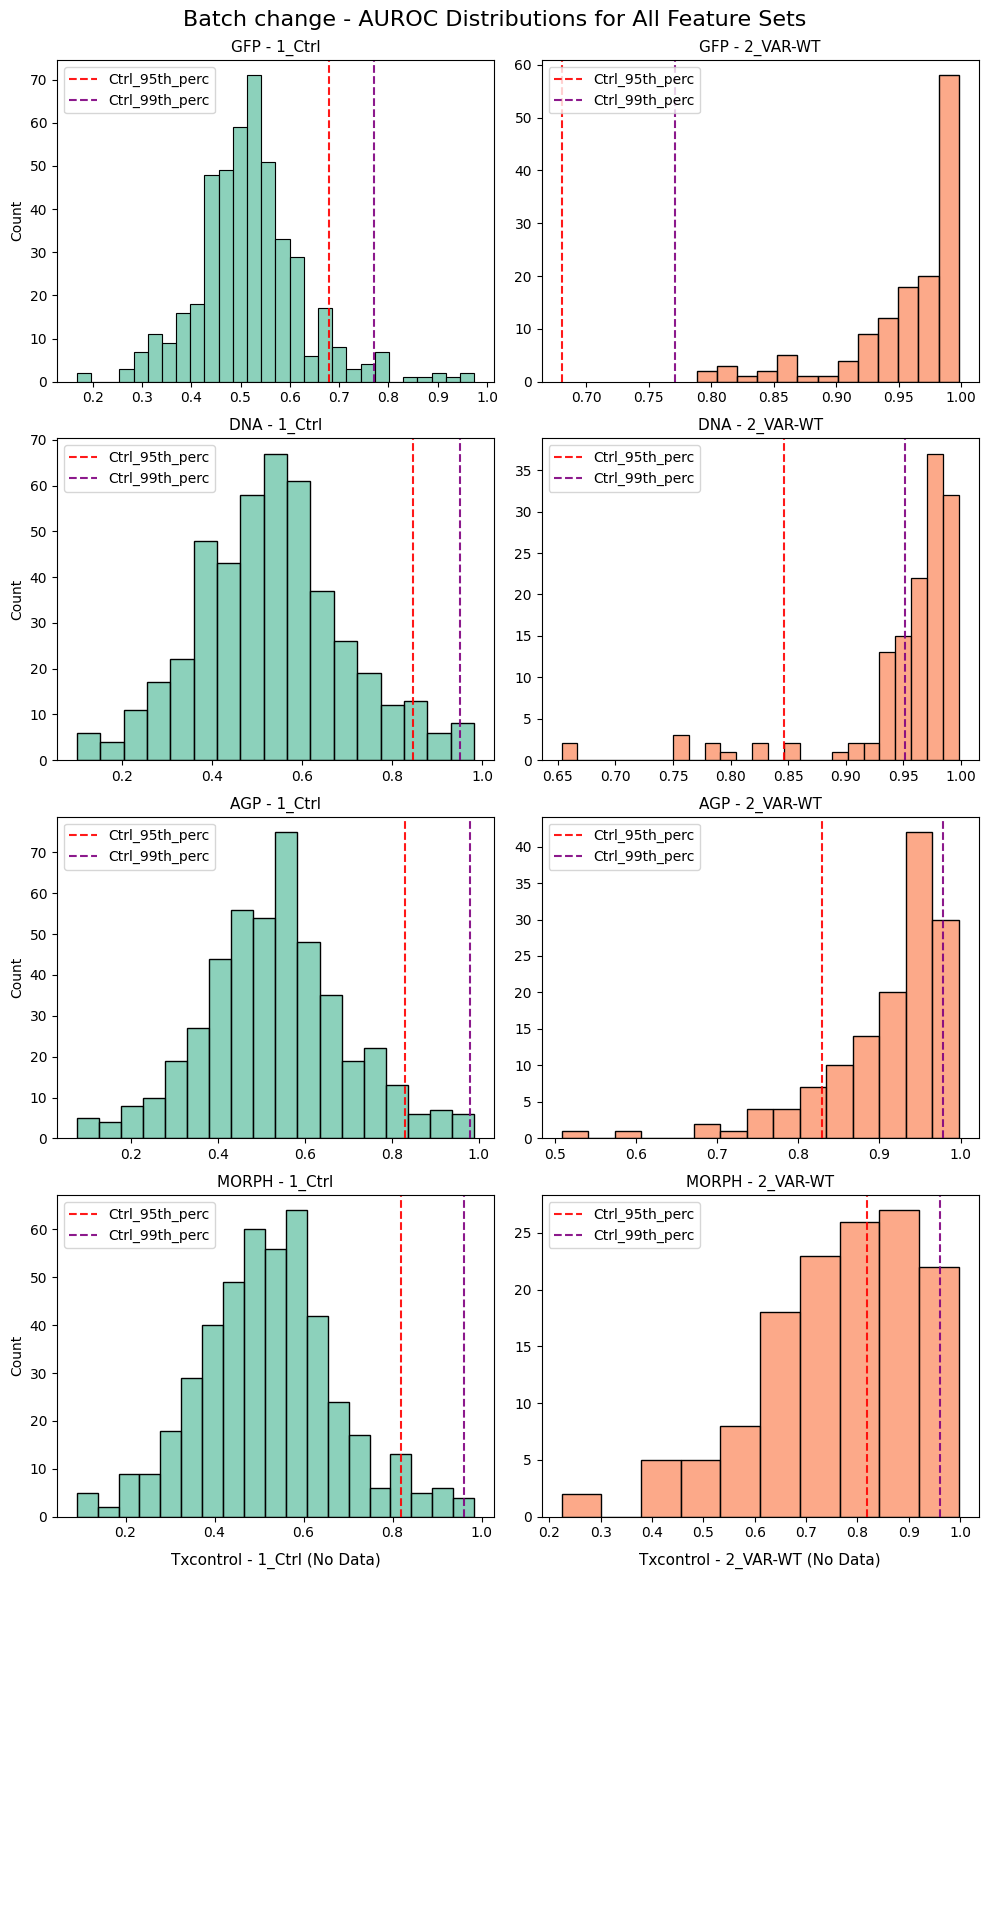

In [42]:
# Get dimensions for subplot grid
n_changes = len(FEAT_SETS)
n_node_types = len(sorted(metrics_df['Node_Type'].unique()))
node_types_sorted = sorted(metrics_df['Node_Type'].unique())

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        batch_num = batch_id.split("_")[-1]
        # Create figure with subplots for this batch
        fig, axes = plt.subplots(
            n_changes, n_node_types, 
            figsize=(5 * n_node_types, 4 * n_changes),
            squeeze=False
        )
        for change_idx, change in enumerate(FEAT_SETS):
            ## Only need to plot for one change, since the other is duplicative
            # if change == "GFP":
            #     df_local = metric_df_dict[f"B{batch_num}_met_thres"].filter(pl.col("Classifier_type") == change)
            #     plot_metric_dist(df_local, value="Training_imbalance", batch=batch_num, col="Node_Type")
            #     plot_metric_dist(df_local, value="trainsize_0", batch=batch_num, col="Node_Type")
            #     plot_metric_dist(df_local, value="trainsize_1", batch=batch_num, col="Node_Type")
            perc_dict = dict([(
                f"{auroc_thres*100:.0f}th_perc", 
                metric_df_dict[f"{batch_id}_met_thres"].filter(pl.col("Classifier_type") == change).select(f"AUROC_thresh_{auroc_thres*100:.0f}").mean().to_numpy()[0][0]
            ) for auroc_thres in AUROC_THRESHOLDS])
    
            # Get filtered data for this batch and change
            plot_data = metric_df_dict[f"{batch_id}_met_thres"].filter(
                (pl.col("Classifier_type") == change) & 
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            ).to_pandas()
            
            # Create subplot for each node type
            for node_idx, node_type in enumerate(node_types_sorted):
                ax = axes[change_idx, node_idx]
                
                # Filter data for this node type
                node_data = plot_data[plot_data['Node_Type'] == node_type]
                
                if not node_data.empty:
                    # Create histogram
                    sns.histplot(
                        data=node_data,
                        x="AUROC",
                        kde=False,
                        ax=ax,
                        color=sns.color_palette("Set2")[node_idx % len(sns.color_palette("Set2"))]
                    )                
                    # Add vertical lines for thresholds
                    colors = ['red', 'purple', 'orange', 'brown']  # Different colors for different thresholds
                    for i, (label, auroc_val) in enumerate(perc_dict.items()):
                        color = colors[i % len(colors)]
                        ax.axvline(auroc_val, color=color, linestyle='--', alpha=0.9, label=f"Ctrl_{label}")
                    ax.legend(loc="upper left")
                    # Set title and labels
                    ax.set_title(f"{change.upper()} - {node_type}", fontsize=11)
                    # Add legend only to the first subplot
                    # if change_idx == 0 and node_idx == 0:
                    #     ax.legend(loc='upper right', fontsize=8)
                else:
                    ax.set_title(f"{change.capitalize()} - {node_type} (No Data)", fontsize=11)
                    ax.axis('off')
                
                # Set labels
                if change_idx == n_changes - 1:  # Bottom row
                    ax.set_xlabel("AUROC")
                else:
                    ax.set_xlabel("")
                    
                if node_idx == 0:  # Left column
                    ax.set_ylabel("Count")
                else:
                    ax.set_ylabel("")
        
        # Add overall title for the batch
        fig.suptitle(f"Batch {batch_num} - AUROC Distributions for All Feature Sets", 
                     fontsize=16, y=0.95)
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=.925)

        # os.makedirs(f"{CLASS_SUMMARY_DIR}/{bio_rep}", exist_ok=True)
        fig.savefig(
            os.path.join(f"{CLASS_SUMMARY_DIR}/{bio_rep}/B{batch_num}_ctrl_var-wt_dist.png"),
            dpi=300,
            bbox_inches="tight"
        )

### 3.1 Correlation between biological replicates

(54, 2)
(38, 2)
(75, 2)
(38, 2)
(50, 2)
(16, 2)
(50, 2)
(16, 2)
(0, 2)
(0, 2)


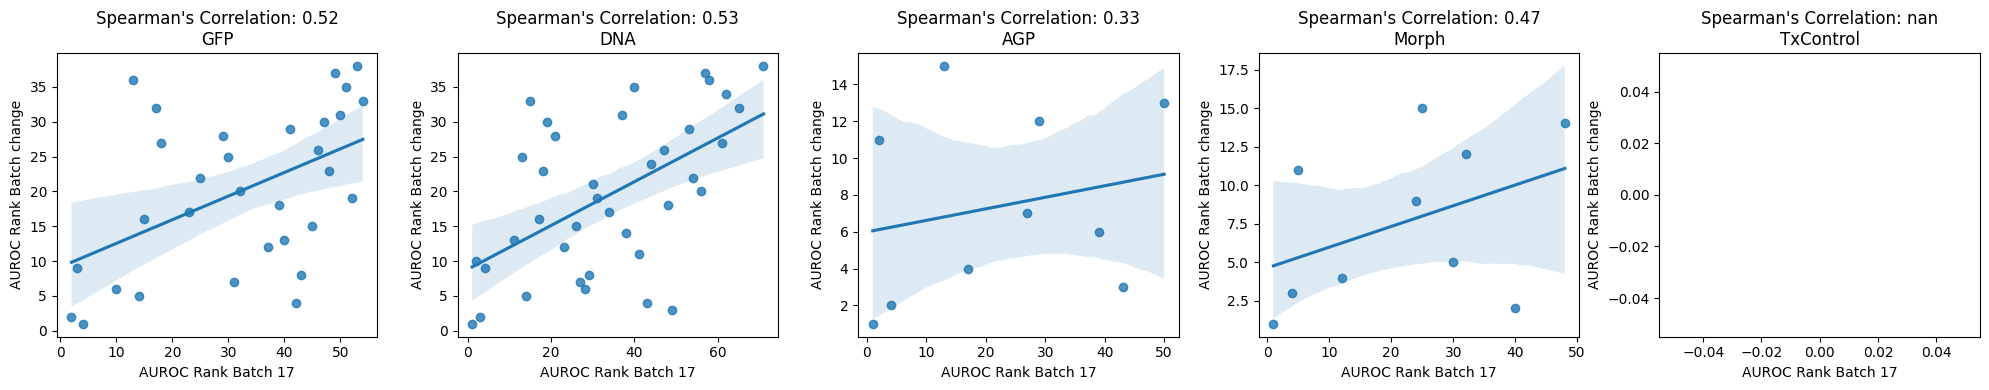

In [51]:
from scipy.stats import spearmanr

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    # print(bio_rep_batches)
    fig, axes = plt.subplots(1, 5, figsize=(20,4))
    for classifier_type in FEAT_SETS:
        # Select the columns "allele_0" and "AUROC_rank" from both dataframes
        set1_ranks = metric_df_dict[f"{bio_rep_batches[0]}_allele_summary"].filter(
            (pl.col("Classifier_type") == classifier_type)
        ).with_columns(
            pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
        ).select(["allele_0", "AUROC_rank"])
        set2_ranks = metric_df_dict[f"{bio_rep_batches[1]}_allele_summary"].filter(
            (pl.col("Classifier_type") == classifier_type)
        ).with_columns(
            pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
        ).select(["allele_0", "AUROC_rank"])
        print(set1_ranks.shape)
        print(set2_ranks.shape)
    
        # print(classifier_type, set1_ranks, set1_ranks)
        # Join the dataframes on the "allele_0" column
        joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_rep2")
        # print(joined_ranks.sort(by="allele_0"))
        # Calculate the Spearman's correlation between the ranks
        spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_rep2"])
        # print(f"Spearman's correlation: {spearman_corr}")
    
        # bio_rep1_thres = metric_df_dict["B13_allele_summary"].filter(
        #     (pl.col("Classifier_type") == classifier_type)
        # )['AUROC_thresh'].unique()[0]
        # bio_rep2_thres = metric_df_dict["B14_allele_summary"].filter(
        #     (pl.col("Classifier_type") == classifier_type)
        # )['AUROC_thresh'].unique()[0]
        
        # Plot the correlation using a regression plot
        sns.regplot(x="AUROC_rank", y="AUROC_rank_rep2", data=joined_ranks.to_pandas(), ax=axes[FEAT_SETS.index(classifier_type)])
        # axes[FEAT_SETS.index(classifier_type)].axvline(bio_rep1_thres, linestyle="dashed", color="tomato")
        # axes[FEAT_SETS.index(classifier_type)].axhline(bio_rep2_thres, linestyle="dashed", color="tomato")
        axes[FEAT_SETS.index(classifier_type)].set_title(f"Spearman's Correlation: {spearman_corr:.2f}\n{classifier_type}")
        axes[FEAT_SETS.index(classifier_type)].set_xlabel(f"AUROC Rank Batch {bio_rep_batches[0].split('_')[-1]}")
        axes[FEAT_SETS.index(classifier_type)].set_ylabel(f"AUROC Rank Batch {bio_rep_batches[1].split('_')[-1]}")
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=.25)
    plt.savefig(
        os.path.join(f"{CLASS_SUMMARY_DIR}/{bio_rep}/AUROC_rank_correlation.png"),
        dpi=300,
        bbox_inches="tight"
    )

In [13]:
# metrics_df.filter(pl.col("Plate")=="2025-03-17_B15A1A2_P1T1").unique(subset="well_0")#.with_columns(pl.col("well_0").alias("well_po"))#.agg(pl.mean)
# categorical mode (exactly your original behavior):

# for platemap in os.listdir(platemap_dir):
#     platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
#     # display(platemap_df)
#     for key, df in metric_df_dict.items():
#         # print(key)
#         if "met_thres" in key:
#             for plate in df["Plate"].unique():
#                 print(plate)
#                 auroc_platemap = platemap_df.with_columns(
#                         pl.concat_str([pl.col("well_position"), pl.col("gene_allele")], separator="_").alias("well_allele")
#                 ).join(
#                     df.filter((pl.col("Plate")==plate)&(pl.col("Metadata_Control"))).unique(subset="well_0").with_columns(
#                         pl.concat_str([pl.col("well_0"), pl.col("allele_0")], separator="_").alias("well_allele")
#                     ),
#                     left_on="well_allele", right_on="well_allele", how="left"
#                 ).filter(pl.col("AUROC").is_not_null())
#                 # display(auroc_platemap)
#                 plot_platemap(
#                     auroc_platemap,
#                     plate_name=plate,
#                     well_pos_col="well_position",
#                     value_col="AUROC",
#                     label_cols=("gene_allele","AUROC"),
#                     value_type="continuous",
#                     continuous_cmap="viridis_r"
#                 )

# metrics_df.filter(pl.col("Plate")=="2025-03-17_B15A1A2_P1T1").unique(subset="well_0")#.with_columns(pl.col("well_0").alias("well_po"))#.agg(pl.mean)
# categorical mode (exactly your original behavior):

# for platemap in os.listdir(platemap_dir):
#     platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
#     for key, df in metric_df_dict.items():
#         if "met_thres" in key:
#             for change in CELL_CHANGES:
#                 df_chg = df.filter(pl.col("Classifier_type") == change)
#                 for plate in df_chg["Plate"].unique():
#                     # print(plate)
#                     auroc_platemap = platemap_df.with_columns(
#                             pl.concat_str([pl.col("well_position"), pl.col("gene_allele")], separator="_").alias("well_allele")
#                     ).join(
#                         df_chg.filter((pl.col("Plate")==plate)&(~pl.col("Metadata_Control"))).unique(subset="well_0").with_columns(
#                             pl.concat_str([pl.col("well_0"), pl.col("allele_0")], separator="_").alias("well_allele")
#                         ),
#                         left_on="well_allele", right_on="well_allele", how="left"
#                     ).filter(pl.col("AUROC").is_not_null())
#                     # display(auroc_platemap)
#                     plot_platemap(
#                         auroc_platemap,
#                         plate_name=f"{plate}_{change}",
#                         well_pos_col="well_position",
#                         value_col="AUROC",
#                         label_cols=("gene_allele","AUROC"),
#                         value_type="continuous",
#                         continuous_cmap="viridis_r"
#                     )

## 4. Calling hits

In [10]:
# def plot_gene_level_summary(total_allele_hit_sum_df, cell_change, auroc_thres):
#     # 1. Fill nulls with 0
#     total_allele_hit_sum_df["len_hits"] = total_allele_hit_sum_df["len_hits"].fillna(0).astype(int)
#     # 2. Compute percentage of hits
#     total_allele_hit_sum_df["pct_hits"] = total_allele_hit_sum_df["len_hits"] / total_allele_hit_sum_df["len"] * 100
#     # 3. Sort by percentage descending
#     total_allele_hit_sum_df = total_allele_hit_sum_df.sort_values(by=["len","pct_hits"], ascending=True).reset_index(drop=True)
    
#     y = range(len(total_allele_hit_sum_df))
#     n_genes = len(y)

#     # 4. Dynamically scale figure size
#     bar_width = 0.4
#     fig_height = max(6, min(n_genes * 0.3, 25))  # cap size for huge plots
#     fig_width = 8
#     fig, ax = plt.subplots(figsize=(fig_width, fig_height))
#     # Plot bars
#     ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
#     ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

#     # Annotate percentage
#     for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
#         ax.text(
#             total_allele_hit_sum_df.loc[i, "len"] + 0.5,
#             i,
#             f"{pct:.1f}%",
#             ha="left",
#             va="center",
#             fontsize=10 if n_genes > 20 else 11,
#             rotation=0,
#         )
#     # Axis formatting
#     ax.set_yticks(y)
#     ax.set_yticklabels(
#         total_allele_hit_sum_df["by"],
#         fontsize=10 if n_genes > 20 else 11,
#     )
#     ax.set_xlabel("Count", fontsize=11)
#     ax.set_title(
#         f"Altered {cell_change.capitalize()} Hits per Gene (AUROC thres: {auroc_thres})",
#         fontsize=13,
#     )
#     ax.set_xlim(0, total_allele_hit_sum_df["len"].max() * 1.1)
#     ax.set_ylim(-1, len(y) + .3)
#     ax.legend(fontsize=11, loc="lower right")
#     # Improve spacing
#     plt.tight_layout()
#     plt.show()
#     return total_allele_hit_sum_df

### 4.1 Call hits per each batch

In [25]:
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    metric_sum_df_dict = {}
    for met_sum_file in glob.glob(f"{CLASS_SUMMARY_DIR}/{bio_rep}/B*/*.csv"):
        metric_sum_df_dict[met_sum_file.split('/')[-2]] = pl.read_csv(met_sum_file)
    metrics_sum_wtvar = pl.concat(list(metric_sum_df_dict.values()))
    for cell_change in FEAT_SETS:
        ## Filter the change to detect
        cell_chg_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == cell_change)
        ## Per each batch, get the hits
        cell_chg_wtvar = cell_chg_wtvar.with_columns([
            pl.when(pl.col("AUROC_mean") > pl.col(f"AUROC_thresh_{auroc*100:.0f}"))
            .then(1)
            .otherwise(0)
            .alias(f"Altered_{cell_change[:5]}_{auroc*100:.0f}")
            for auroc in AUROC_THRESHOLDS
        ]).unique()
    
        ## Create separate pivot tables for each threshold and combine them
        all_threshold_dfs = []
        for auroc in AUROC_THRESHOLDS:
            threshold_name = f"{auroc*100:.0f}"
            # Create pivot for this threshold
            threshold_df = (
                cell_chg_wtvar.pivot(
                    index=["allele_0"],
                    on="Batch",
                    values=f"Altered_{cell_change[:5]}_{threshold_name}",
                )
                # Rename batch columns to include threshold
                .rename({
                    f"B{batch.split('_')[-1]}": f"Altered_{cell_change[:5]}_{threshold_name}_BioRep{idx+1}"
                    for idx, batch in enumerate(bio_rep_batches)
                })
                .with_columns(
                    # Create a list of batch columns
                    pl.concat_list([
                        pl.col(f"Altered_{cell_change[:5]}_{threshold_name}_BioRep{idx+1}")==1
                        for idx, batch in enumerate(bio_rep_batches)
                    ]).alias("batch_values")
                )
                .with_columns(
                    # Check if all non-null values are 1, and at least one value is 1
                    (pl.col("batch_values").list.drop_nulls().list.all()).alias(f"Altered_{cell_change[:5]}_{threshold_name}_both_batches")
                    # (pl.col("batch_values").list.drop_nulls().list.any()).alias(f"Altered_{cell_change[:5]}_{threshold_name}_any_batches")
                )
                .drop("batch_values")  # Remove helper column
            )
            all_threshold_dfs.append(threshold_df)
        
        ## Combine all threshold dataframes using reduce and join
        change_binary = reduce(
            lambda left, right: left.join(right, on="allele_0", how="full", coalesce=True),
            all_threshold_dfs
        )
        
        # Store the result
        # For example: change_binary_dict[cell_change] = change_binary
        # ## Per combine the hits from both batches
        # change_binary = (
        #     cell_chg_wtvar.pivot(
        #         index=["allele_0"], ## , "Allele_set"
        #         on="Batch",
        #         values=f"Altered_{cell_change[:5]}",
        #     )
        #     # 1) rename each pivoted batch-column
        #     .rename({f"B{batch.split('_')[-1]}": f"Altered_{cell_change[:5]}_batch{batch.split('_')[-1]}" for batch in BIO_REP_BATCHES})
        #     # 2) add the “both” column by AND-reducing all of them
        #     .with_columns(
        #         reduce(
        #             operator.and_,
        #             [pl.col(f"Altered_{cell_change[:5]}_batch{batch.split('_')[-1]}") == 1 for batch in BIO_REP_BATCHES]
        #         ).alias(f"Altered_{cell_change[:5]}_both_batches")
        #     )
        # )
        
        ## Per combine the AUROC scores from both batches
        change_auroc = cell_chg_wtvar.pivot(
            index=["allele_0"],
            on="Batch",
            values="AUROC_mean",
        ).rename(
            {f"B{batch.split('_')[-1]}": f"AUROC_BioRep{idx+1}" for idx, batch in enumerate(bio_rep_batches)}
        ).with_columns(
            pl.mean_horizontal(
                [
                    pl.col(f"AUROC_BioRep{idx+1}")
                    for idx, batch in enumerate(bio_rep_batches)
                ]#, ignore_nulls=True
            ).alias("AUROC_Mean")
        )
        change_summary = change_binary.join(change_auroc, on="allele_0")
    
        for auroc in AUROC_THRESHOLDS:
            threshold_name = f"{auroc*100:.0f}"
            total_allele_hit_sum_df = allele_meta_df.filter(
                (pl.col("node_type")=="allele")&(pl.col("plate_map_name").str.contains(bio_rep_batches[0].split('_')[-1]))&(pl.col("gene_allele").is_not_null())
            ).unique(subset="gene_allele").group_by(by="symbol").len().sort(by="len", descending=True).join(
                change_summary.filter(pl.col(f"Altered_{cell_change[:5]}_{threshold_name}_both_batches")).with_columns(
                pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("symbol")
            ).group_by(by="symbol").len().sort(by="len", descending=True), on="by", suffix="_hits", how="left").to_pandas()
    
        # if os.path.exists(f"{CLASS_RES_OUTDIR}/{bio_rep}/altered_{cell_change[:5]}_summary_auroc.csv"):
        #     print(f"AUROC summary exists at: {CLASS_RES_OUTDIR}/{bio_rep}/altered_{cell_change[:5]}_summary_auroc.csv")
        # else:
        print(f"AUROC summary output at: {CLASS_SUMMARY_DIR}/{bio_rep}/altered_{cell_change[:5]}_summary_auroc.csv")
        change_summary.write_csv(f"{CLASS_SUMMARY_DIR}/{bio_rep}/altered_{cell_change[:5]}_summary_auroc.csv")

AUROC summary output at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/outputs/2.classification_results/2024_01_Batch_7-8/altered_GFP_summary_auroc.csv
AUROC summary output at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/outputs/2.classification_results/2024_01_Batch_7-8/altered_DNA_summary_auroc.csv
AUROC summary output at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/outputs/2.classification_results/2024_01_Batch_7-8/altered_Mito_summary_auroc.csv
AUROC summary output at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/outp

In [27]:
change_summary.filter(
    (~pl.col("Altered_Morph_95_both_batches")) & ((pl.col("Altered_Morph_95_BioRep1")==0) | (pl.col("Altered_Morph_95_BioRep2")==0))
)

allele_0,Altered_Morph_95_BioRep1,Altered_Morph_95_BioRep2,Altered_Morph_95_both_batches,Altered_Morph_99_BioRep1,Altered_Morph_99_BioRep2,Altered_Morph_99_both_batches,AUROC_BioRep1,AUROC_BioRep2,AUROC_Mean
str,i32,i32,bool,i32,i32,bool,f64,f64,f64
"""GBA_ARG301HIS""",0,0,false,0,0,false,0.506303,0.5269,0.516601
"""PSEN1_Leu250Ser""",0,0,false,0,0,false,0.71946,0.824955,0.772207
"""PSEN1_Leu381Val""",0,1,false,0,0,false,0.895627,0.965605,0.930616
"""GBA_LYS512TER""",0,0,false,0,0,false,0.618225,0.842346,0.730285
"""PSEN1_Met146Leu""",0,0,false,0,0,false,0.805065,0.454498,0.629782
…,…,…,…,…,…,…,…,…,…
"""GBA_Ala308Thr""",0,0,false,0,0,false,0.577133,0.6402,0.608667
"""GBA_Val211Ile""",0,null,false,0,null,false,0.753256,null,0.753256
"""GBA_HIS529ARG""",0,0,false,0,0,false,0.649952,0.771195,0.710574


### 4.2 Merge batches together

In [28]:
change_summary_df = pl.DataFrame()
for cell_change in FEAT_SETS:
    for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
        change_summ = pl.read_csv(f"{CLASS_SUMMARY_DIR}/{bio_rep}/altered_{cell_change[:5]}_summary_auroc.csv")
        # display(change_summ.filter(pl.col("allele_0")=="MVK_Ser329Asn"))
        change_summ_auroc_cols = sorted([col for col in change_summ.columns if col.startswith("AUROC_batch")])
        change_summ_altered_cols = sorted([col for col in change_summ.columns if col.endswith("_batches") or col.startswith("Altered")])
        # print(["_".join([col.split("_")[0],col.split("_")[2]+"th_perc"]) for col in change_summ_altered_cols])
        change_summ = change_summ.with_columns(
            # [pl.col(col).alias(f"AUROC_BioRep{idx+1}") for idx, col in enumerate(change_summ_auroc_cols)] +
            [pl.col(col).alias("_".join([col.split("_")[0],col.split("_")[2]+"th_perc_"+'_'.join(col.split("_")[-2:])])) for idx, col in enumerate(change_summ_altered_cols)]
        ).rename(
            {"allele_0": "gene_allele"}
        ).with_columns(
            pl.lit(cell_change).alias("channel"),
            pl.lit(bio_rep).alias("Metadata_Bio_Batch")
        )
        # .select(pl.col(["gene_allele","AUROC_Mean",
        #                  "Altered_95th_perc_both_batches",
        #                  "Altered_99th_perc_both_batches",
        #                  "AUROC_BioRep1","AUROC_BioRep2",
        #                  "channel","Metadata_Bio_Batch"]))
        change_summary_df = pl.concat([change_summ, change_summary_df], how="diagonal_relaxed")

In [29]:
change_summary_df_gfp = change_summary_df.filter(pl.col("channel")=="GFP")
with pl.Config(set_tbl_rows=20):
    display(change_summary_df_gfp.filter(change_summary_df_gfp.select(pl.col(["gene_allele"])).is_duplicated()).sort("gene_allele"))

gene_allele,Altered_Morph_95_BioRep1,Altered_Morph_95_BioRep2,Altered_Morph_95_both_batches,Altered_Morph_99_BioRep1,Altered_Morph_99_BioRep2,Altered_Morph_99_both_batches,AUROC_BioRep1,AUROC_BioRep2,AUROC_Mean,Altered_95th_perc_95_BioRep1,Altered_95th_perc_95_BioRep2,Altered_95th_perc_both_batches,Altered_99th_perc_99_BioRep1,Altered_99th_perc_99_BioRep2,Altered_99th_perc_both_batches,channel,Metadata_Bio_Batch,Altered_AGP_95_BioRep1,Altered_AGP_95_BioRep2,Altered_AGP_95_both_batches,Altered_AGP_99_BioRep1,Altered_AGP_99_BioRep2,Altered_AGP_99_both_batches,Altered_Mito_95_BioRep2,Altered_Mito_95_BioRep1,Altered_Mito_95_both_batches,Altered_Mito_99_BioRep2,Altered_Mito_99_BioRep1,Altered_Mito_99_both_batches,Altered_DNA_95_BioRep1,Altered_DNA_95_BioRep2,Altered_DNA_95_both_batches,Altered_DNA_99_BioRep1,Altered_DNA_99_BioRep2,Altered_DNA_99_both_batches,Altered_GFP_95_BioRep2,Altered_GFP_95_BioRep1,Altered_GFP_95_both_batches,Altered_GFP_99_BioRep2,Altered_GFP_99_BioRep1,Altered_GFP_99_both_batches
str,i64,i64,bool,i64,i64,bool,f64,f64,f64,i64,i64,bool,i64,i64,bool,str,str,i64,i64,bool,i64,i64,bool,i64,i64,bool,i64,i64,bool,i64,i64,bool,i64,i64,bool,i64,i64,bool,i64,i64,bool
"""AGXT_Asp201Asn""",null,null,null,null,null,null,0.95344,0.985351,0.969396,1,1,true,1,1,true,"""GFP""","""2024_12_Batch_11-12""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,1,true,1,1,true
"""AGXT_Asp201Asn""",null,null,null,null,null,null,0.913508,0.940724,0.927116,0,1,false,0,0,false,"""GFP""","""2024_01_Batch_7-8""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,0,false,0,0,false
"""BCL10_Leu8Leu""",null,null,null,null,null,null,0.663309,0.764702,0.714005,0,0,false,0,0,false,"""GFP""","""2025_01_Batch_13-14""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,false,0,0,false
"""BCL10_Leu8Leu""",null,null,null,null,null,null,0.682504,0.564449,0.623477,0,0,false,0,0,false,"""GFP""","""2024_01_Batch_7-8""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,false,0,0,false
"""GSS_Arg125Cys""",null,null,null,null,null,null,0.763212,0.548967,0.656089,0,0,false,0,0,false,"""GFP""","""2025_01_Batch_13-14""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,false,0,0,false
"""GSS_Arg125Cys""",null,null,null,null,null,null,0.758222,0.731739,0.744981,1,0,false,0,0,false,"""GFP""","""2024_12_Batch_11-12""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,1,false,0,0,false
"""GSS_Arg125Cys""",null,null,null,null,null,null,0.892405,0.635237,0.763821,0,0,false,0,0,false,"""GFP""","""2024_01_Batch_7-8""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,false,0,0,false
"""HPRT1_His204Asp""",null,null,null,null,null,null,0.990219,0.983797,0.987008,1,1,true,1,1,true,"""GFP""","""2024_12_Batch_11-12""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,1,true,1,1,true
"""HPRT1_His204Asp""",null,null,null,null,null,null,0.991273,0.975594,0.983434,1,1,true,1,0,false,"""GFP""","""2024_01_Batch_7-8""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,1,true,0,1,false


In [30]:
## HARD Code to filter bad quality measurements
change_summary_df = change_summary_df.filter(
    ~((pl.col("gene_allele")=="AGXT_Asp201Asn")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="MVK_Pro288Leu")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="GSS_Arg125Cys")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="GSS_Arg125Cys")&(pl.col("Metadata_Bio_Batch")=="2024_12_Batch_11-12")) &
    ~((pl.col("gene_allele")=="HPRT1_His204Asp")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="MVK_Ser329Asn")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="RAD51D_Arg165Gln")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8")) &
    ~((pl.col("gene_allele")=="BCL10_Leu8Leu")&(pl.col("Metadata_Bio_Batch")=="2024_01_Batch_7-8"))
)

## 5. Output to files

In [36]:
# 1. Unpivot the value columns from wide to long format
unpivoted = change_summary_df.unpivot(
    index=["gene_allele", "channel", "Metadata_Bio_Batch"],
    on=["AUROC_BioRep1", "AUROC_BioRep2", "AUROC_Mean", 
        "Altered_95th_perc_both_batches", "Altered_99th_perc_both_batches",
       ],
    variable_name="variable",
    value_name="value"
)
# 2. Create combined column names with suffixes: e.g. value1_A
unpivoted = unpivoted.with_columns(
    (pl.col("variable") + "_" + pl.col("channel")).alias("var_cat")
)
# 3. Pivot on 'id' with new combined column names
auroc_summary = unpivoted.pivot(
    values="value",
    index=["gene_allele","Metadata_Bio_Batch"],
    on="var_cat",
    aggregate_function="first"
).with_columns(
    pl.col("gene_allele").str.split("_").list.get(0).alias("symbol")
)

altered_cols = [f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS] + \
[f"Altered_99th_perc_both_batches_{feat}" for feat in FEAT_SETS]
prioritized_cols = ["symbol", "gene_allele", "Metadata_Bio_Batch"] + altered_cols + [f"AUROC_Mean_{feat}" for feat in FEAT_SETS]

auroc_summary = auroc_summary.select(
    prioritized_cols + [c for c in auroc_summary.columns if c not in prioritized_cols]
).with_columns(
    [pl.col(c).cast(pl.Boolean).alias(c) for c in altered_cols]
)
auroc_summary.write_csv(f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_all.csv")

In [37]:
auroc_summary

symbol,gene_allele,Metadata_Bio_Batch,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph,Altered_99th_perc_both_batches_GFP,Altered_99th_perc_both_batches_DNA,Altered_99th_perc_both_batches_Mito,Altered_99th_perc_both_batches_AGP,Altered_99th_perc_both_batches_Morph,AUROC_Mean_GFP,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,AUROC_Mean_Morph,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep1_GFP,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_BioRep2_GFP
str,str,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""GBA""","""GBA_ARG301HIS""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,0.685993,0.432165,0.655557,0.634267,0.516601,0.506303,0.60218,0.697947,0.482781,0.632444,0.5269,0.666355,0.613166,0.38155,0.739542
"""PSEN1""","""PSEN1_Leu250Ser""","""2025_06_Batch_18-19""",true,true,true,true,false,true,true,true,true,false,0.998358,0.994344,0.99533,0.989865,0.772207,0.71946,0.988575,0.992594,0.99445,null,0.824955,0.991154,0.998065,0.994237,0.998358
"""GBA""","""GBA_Asp448His""","""2025_06_Batch_18-19""",true,true,false,true,true,false,true,false,true,false,0.990424,0.957124,0.977129,0.984063,0.96733,0.963458,0.983135,0.963502,0.943398,0.984981,0.971201,0.984991,0.990755,0.97085,0.995868
"""PSEN1""","""PSEN1_Leu381Val""","""2025_06_Batch_18-19""",false,false,false,true,false,false,false,false,false,false,0.885101,0.712578,0.941842,0.934487,0.930616,0.895627,0.941532,0.959491,0.74231,0.950227,0.965605,0.927441,0.924192,0.682846,0.819976
"""GBA""","""GBA_LYS512TER""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,0.852303,0.631872,0.805145,0.768661,0.730285,0.618225,0.624961,0.688994,0.54986,0.737518,0.842346,0.912361,0.921297,0.713885,0.967088
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""COMP""","""COMP_Cys348Arg""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,0.878607,0.885403,0.867017,0.781096,0.912494,0.912494,0.853675,0.897148,0.885403,0.923016,null,0.708517,0.836885,null,0.834198
"""GCK""","""GCK_Arg377His""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,0.759726,0.557682,0.689029,0.702714,0.582422,0.582422,0.702714,0.689029,0.557682,0.759726,null,null,null,null,null
"""GCK""","""GCK_Gly175Arg""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,0.88123,0.689025,0.835236,0.786208,0.717702,0.717702,0.786208,0.835236,0.689025,0.88123,null,null,null,null,null


In [38]:
auroc_summary_one_perc = auroc_summary.filter(
    pl.col("Metadata_Bio_Batch")!="2025_06_Batch_18-19",
    ~pl.col("gene_allele").str.contains("CCM2")
)
auroc_summary_one_perc.write_csv(f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_one_perc.csv")

## 5. ClinVar

In [42]:
sys.path.insert(1, f"{ALLELE_COLLECT_DIR}/2_analysis")
from plot_utils import *

In [43]:
clin_var_annot_df = pl.read_csv(f"{ALLELE_COLLECT_DIR}/3_outputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules.tsv", separator="\t", infer_schema_length=10000)
clin_var_annot_df = clin_var_annot_df.with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_allele")
)
# change_summary_df = pl.read_csv(f"{CLASS_SUMMARY_DIR}/imaging_analyses_classification_summary_one_perc.csv")

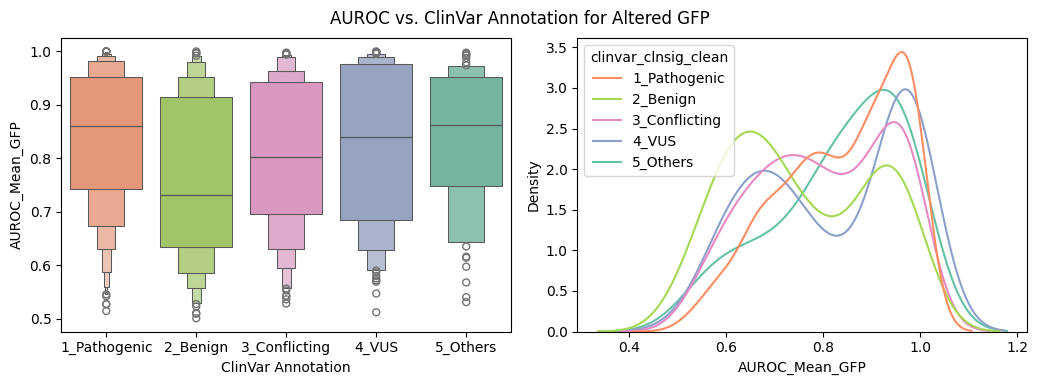

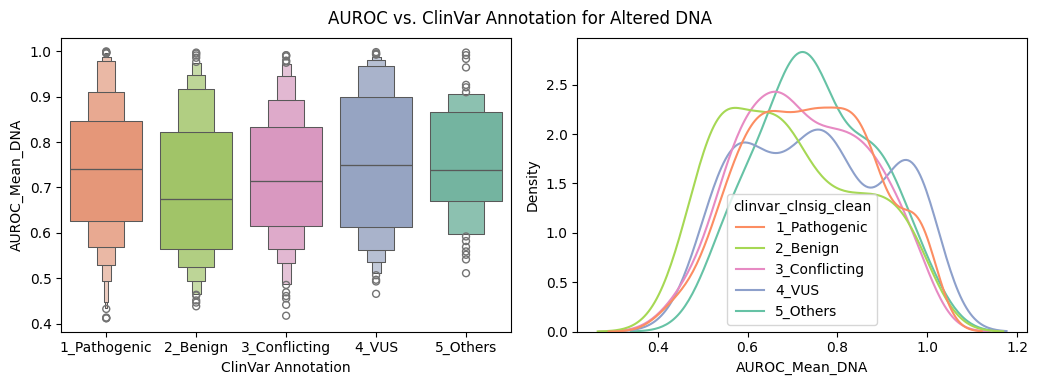

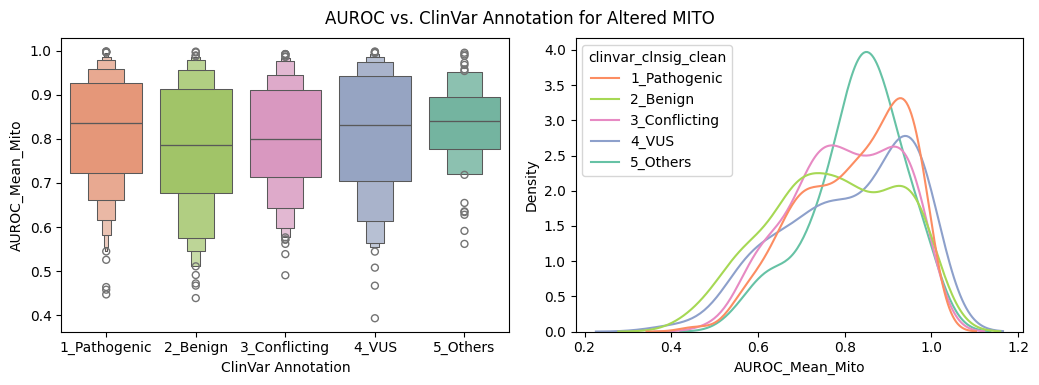

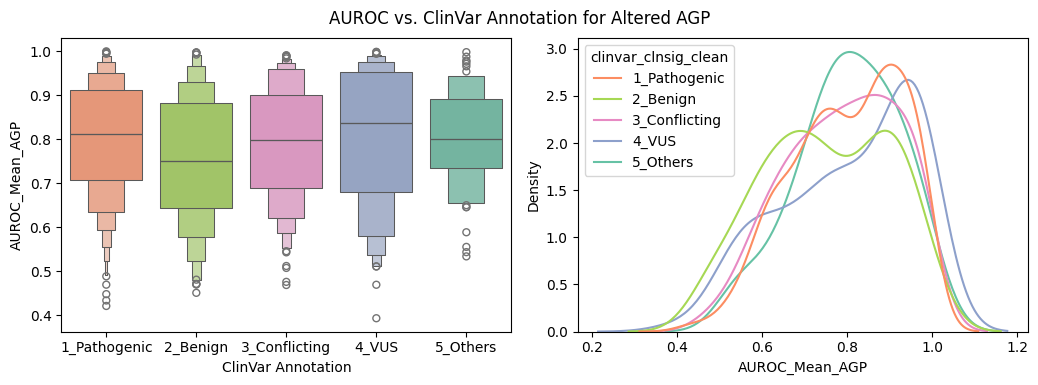

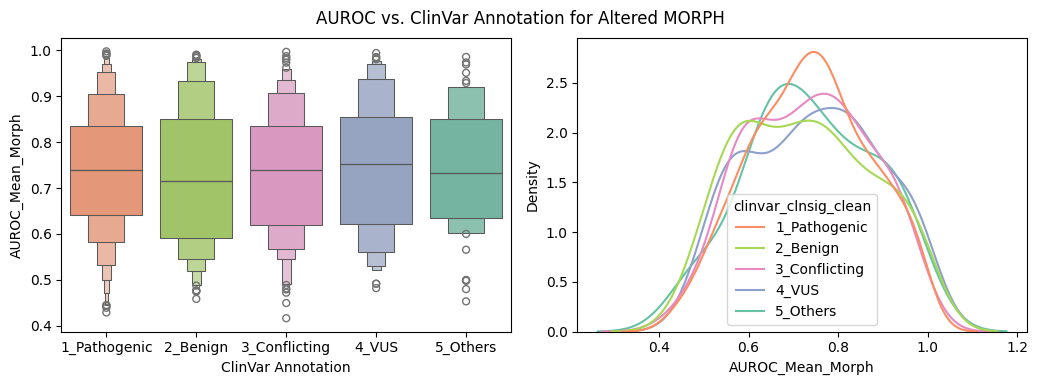

In [48]:
for change in FEAT_SETS:
    fig, ax = plt.subplots(1,2,figsize=(10.5, 4))
    summary_clin_var = clin_var_annot_df.join(
        change_summary_df, 
        on=["gene_allele"]
    )
    sns.boxenplot(data=summary_clin_var.to_pandas(), palette=palette_dict["clinvar_clnsig_clean"], 
                  x="clinvar_clnsig_clean_dbnsfp", y=f"AUROC_Mean_{change}", ax=ax[0],
                  hue="clinvar_clnsig_clean", saturation=.7,
                  order=sorted(clin_var_annot_df["clinvar_clnsig_clean"].drop_nulls().unique()),
                  hue_order=sorted(clin_var_annot_df["clinvar_clnsig_clean"].drop_nulls().unique())
                 )
    # sns.swarmplot(data=summary_clin_var.to_pandas(), palette=palette_dict["clinvar_clnsig_clean"],
    #               x="clinvar_clnsig_clean_dbnsfp", y=f"AUROC_Mean_{change}", 
    #               ax=ax[0], order=sorted(clin_var_annot_df["clinvar_clnsig_clean"].drop_nulls().unique()))
    ax[0].set_xlabel("ClinVar Annotation")
    ax[0].get_legend().remove()
    
    fig.suptitle(f"AUROC vs. ClinVar Annotation for Altered {change.upper()}", y=.95)
    sns.kdeplot(
        data=summary_clin_var.to_pandas(), ## .filter(pl.col("clinvar_clnsig_clean")!="5_Others")
        x=f"AUROC_Mean_{change}",
        common_norm=False,
        ax=ax[1],
        palette=palette_dict["clinvar_clnsig_clean"],
        hue="clinvar_clnsig_clean",
        # col="clinvar_clnsig_clean_dbnsfp",
        # col_order=sorted(summary_clin_var.filter(pl.col("clinvar_clnsig_clean_dbnsfp")!="5_Others")["clinvar_clnsig_clean_dbnsfp"].drop_nulls().unique()),
        hue_order=sorted(summary_clin_var["clinvar_clnsig_clean"].drop_nulls().unique())
    )
    plt.tight_layout()